# Proyecto Integrador — Pipeline incremental de datos

 1 Importar librerías y configurar rutas

In [116]:
# 1) Importar librerías y configurar rutas
import sqlite3
from pathlib import Path
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick


# Rutas (definimos project_root antes de intentar importar desde 'src')
project_root = Path('..')
# Asegurar que la carpeta del proyecto (que contiene 'src') esté en sys.path
# Esto permite importar 'src.proyecto_integrador' desde el notebook
sys.path.insert(0, str(project_root.resolve()))

# Clase de ayuda para descargar/extract (usa kagglehub)
from src.proyecto_integrador.ingestar import Ingestar

db_dir = project_root / 'db'
db_dir.mkdir(parents=True, exist_ok=True)
db_path = db_dir / 'proyecto.db'

csv_dir = project_root / 'csv'
csv_dir.mkdir(parents=True, exist_ok=True)
output_csv = csv_dir / 'export.csv'

# Parámetros
KAGGLE_REF = 'priyamchoksi/credit-card-transactions-dataset'
CHUNK_SIZE = 100_000  # filas por chunk al leer CSV
UNIQUE_ID_COL = 'trans_num'  # columna única para evitar duplicados

 2 Descargar y extraer (si es necesario)

In [117]:
# 2) Descargar y extraer
ing = Ingestar()
dataset_path = ing.download_dataset_zip(KAGGLE_REF)
data_dir = ing.extract_zip_files(dataset_path)

📥 Dataset descargado: C:\Users\eulic\.cache\kagglehub\datasets\priyamchoksi\credit-card-transactions-dataset\versions\1
📄 1 archivo(s) CSV encontrado(s)


In [118]:
# 3) Carga a SQLite — usando función del módulo load_to_sqlite
from src.proyecto_integrador.load_to_sqlite import insertar_datos
import pandas as pd
import os
import sqlite3

# Busca archivos CSV en la carpeta de datos
csv_files = [f for f in os.listdir(data_dir) if f.endswith('.csv')]
if not csv_files:
    raise FileNotFoundError('No se encontraron archivos CSV en la carpeta de dataset')

# Leer y concatenar todos los CSV en un único DataFrame
dfs = []
for csv_file in csv_files:
    path = os.path.join(data_dir, csv_file)
    print(f'Leyendo {path}...')
    df_tmp = pd.read_csv(path, low_memory=False)
    dfs.append(df_tmp)

df_all = pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

if df_all.empty:
    print('No hay filas en los CSV; la tabla no será creada.')
else:
    # Conectar a SQLite y usar la función del módulo
    conn = sqlite3.connect(db_path, timeout=60)
    insertar_datos(conn, df_all)
    conn.close()

Leyendo C:\Users\eulic\.cache\kagglehub\datasets\priyamchoksi\credit-card-transactions-dataset\versions\1\credit_card_transactions.csv...
 1,296,675 registros insertados en la base de datos


In [119]:
# 4) Exportar tabla completa a CSV (usando función del módulo export_to_csv)
from src.proyecto_integrador.export_to_csv import exportar_tabla_a_csv

exportar_tabla_a_csv(db_path, output_csv)

 1,296,675 registros exportados a ..\csv\export.csv


transformacion de datos y enriquecimiento

In [120]:
from pathlib import Path
from IPython.display import display

# Ruta del proyecto (el notebook está dentro de notebooks/)
project_root = Path('..').resolve()          # sube al directorio raíz del proyecto

# Base de datos SQLite que contiene la tabla `transacciones`
db_path = project_root / 'db' / 'proyecto.db'

# Carpeta donde guardaremos los CSV generados 
data_dir = project_root / 'data'
data_dir.mkdir(parents=True, exist_ok=True)   # crea la carpeta si no existe

print(f" DB  : {db_path}")
print(f" DATA: {data_dir}")

# 1️  Leer datos de la base de datos
print("\nLeyendo datos de la tabla 'transacciones'...")
conn = sqlite3.connect(str(db_path))
try:
    df_raw = pd.read_sql_query("SELECT * FROM transacciones", conn)
    print(f"  Se cargaron {len(df_raw):,} filas")
finally:
    conn.close()


# Definir ruta de salida del CSV enriquecido
# Cambia el nombre del archivo
enriched_csv = data_dir / 'dataset_enriquecido.csv'


# Ejecutar la función de limpieza
# Importamos la función del módulo
from src.proyecto_integrador.limpiar_datos import limpiar_dataset

# Esta llamada imprimirá el reporte paso a paso
df_clean = limpiar_dataset(df_raw, guardar_en=str(enriched_csv))

# Guardar el resultado en una nueva tabla SQLite
conn = sqlite3.connect(str(db_path))
try:
    df_clean.to_sql('transacciones_enriquecidas', conn,
                    if_exists='replace', index=False)
    print(f"\n Tabla 'transacciones_enriquecidas' guardada exitosamente en {db_path}")
finally:
    conn.close()


# Mostrar una muestra del DataFrame limpio

display(df_clean.head())

 DB  : C:\Users\eulic\Documents\Proyecto integrado 5\piv_2025_2_2\db\proyecto.db
 DATA: C:\Users\eulic\Documents\Proyecto integrado 5\piv_2025_2_2\data

Leyendo datos de la tabla 'transacciones'...
  Se cargaron 1,296,675 filas

LIMPIEZA DE DATOS - PROYECTO INTEGRADOR 5

Variables del analisis:
   - gender, city, state, lat, long, city_pop
   - merchant, category, merch_lat, merch_long
   - amt, trans_date_trans_time
   - Derivadas: state_name, anio, mes, dia, hora

[PASO 1] Seleccionando columnas necesarias para el analisis
   - Filas totales: 1,296,675
   - Columnas seleccionadas: 13 de 24 originales
   - Filas aceptadas: 1,296,675

[PASO 2] Eliminando transacciones duplicadas
   - Criterio: Numero de transaccion (trans_num)
   - Filas duplicadas encontradas: 0
   - Filas eliminadas: 0
   - Filas aceptadas: 1,296,675

[PASO 3] Limpiando columna 'gender' (genero del titular)
   - Transformacion: Convertir a mayusculas y eliminar espacios
   - Valores nulos encontrados: 0
   - Valores 

,trans_num,trans_date_trans_time,gender,city,state,lat,long,city_pop,merchant,category,amt,merch_lat,merch_long,state_name,anio,mes,dia,hora
0,0b242abb623afc578575680df30655b9,2019-01-01 00:00:18,F,Moravian Falls,NC,36.0788,-81.1781,3495,"fraud_Rippin, Kub and Mann",misc_net,4.97,36.011293,-82.048315,North Carolina,2019,1,1,0
1,1f76529f8574734946361c461b024d99,2019-01-01 00:00:44,F,Orient,WA,48.8878,-118.2105,149,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,49.159047,-118.186462,Washington,2019,1,1,0
2,a1a22d70485983eac12b5b88dad1cf95,2019-01-01 00:00:51,M,Malad City,ID,42.1808,-112.2620,4154,fraud_Lind-Buckridge,entertainment,220.11,43.150704,-112.154481,Idaho,2019,1,1,0
3,6b849c168bdad6f867558c3793159a81,2019-01-01 00:01:16,M,Boulder,MT,46.2306,-112.1138,1939,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,47.034331,-112.561071,Montana,2019,1,1,0
4,a41d7549acf90789359a9aa5346dcb46,2019-01-01 00:03:06,M,Doe Hill,VA,38.4207,-79.4629,99,fraud_Keeling-Crist,misc_pos,41.96,38.674999,-78.632459,Virginia,2019,1,1,0


## 5 Comprobaciones básicas de la base de datos


### 5.1 Listar tablas disponibles

Esta celda lista las tablas presentes en la base de datos SQLite.

In [121]:

try:
    db_path
except NameError:
    db_path = Path('..') / 'db' / 'proyecto.db'
db_path = Path(db_path)
print(f"Usando base de datos: {db_path.resolve()}")

if not db_path.exists():
    raise FileNotFoundError(f'No se encontró la base de datos en {db_path}')

conn = sqlite3.connect(str(db_path))
try:
    tables_df = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';", conn)
    display(tables_df)
finally:
    conn.close()

Usando base de datos: C:\Users\eulic\Documents\Proyecto integrado 5\piv_2025_2_2\db\proyecto.db


,name
0,transacciones
1,transacciones_enriquecidas


### Conteo de filas por tabla

 calculamos el número de filas de cada tabla para detectar tablas vacías o tamaños inesperados.

In [122]:
try:
    db_path
except NameError:
    db_path = Path('..') / 'db' / 'proyecto.db'
conn = sqlite3.connect(str(db_path))
try:
    tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';", conn)['name'].tolist()
    counts = []
    for t in tables:
        c = pd.read_sql_query(f'SELECT COUNT(*) AS cnt FROM "{t}";', conn).iloc[0,0]
        counts.append({'table': t, 'rows': c})
    display(pd.DataFrame(counts))
finally:
    conn.close()

,table,rows
0,transacciones,1296675
1,transacciones_enriquecidas,1296675


###  Filas de ejemplo

 mostramos hasta 5 filas por tabla para inspección rápida de datos y tipos.

In [123]:

try:
    db_path
except NameError:
    db_path = Path('..') / 'db' / 'proyecto.db'
conn = sqlite3.connect(str(db_path))
try:
    tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';", conn)['name'].tolist()
    for t in tables:
        print('\n' + '-'*60)
        print(f"Ejemplos de filas para: {t}")
        df = pd.read_sql_query(f'SELECT * FROM "{t}" LIMIT 5;', conn)
        display(df)
finally:
    conn.close()


------------------------------------------------------------
Ejemplos de filas para: transacciones


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,merch_zipcode
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,28705.0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,NaN
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,83236.0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,NaN
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,22844.0



------------------------------------------------------------
Ejemplos de filas para: transacciones_enriquecidas


,trans_num,trans_date_trans_time,gender,city,state,lat,long,city_pop,merchant,category,amt,merch_lat,merch_long,state_name,anio,mes,dia,hora
0,0b242abb623afc578575680df30655b9,2019-01-01 00:00:18,F,Moravian Falls,NC,36.0788,-81.1781,3495,"fraud_Rippin, Kub and Mann",misc_net,4.97,36.011293,-82.048315,North Carolina,2019,1,1,0
1,1f76529f8574734946361c461b024d99,2019-01-01 00:00:44,F,Orient,WA,48.8878,-118.2105,149,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,49.159047,-118.186462,Washington,2019,1,1,0
2,a1a22d70485983eac12b5b88dad1cf95,2019-01-01 00:00:51,M,Malad City,ID,42.1808,-112.2620,4154,fraud_Lind-Buckridge,entertainment,220.11,43.150704,-112.154481,Idaho,2019,1,1,0
3,6b849c168bdad6f867558c3793159a81,2019-01-01 00:01:16,M,Boulder,MT,46.2306,-112.1138,1939,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,47.034331,-112.561071,Montana,2019,1,1,0
4,a41d7549acf90789359a9aa5346dcb46,2019-01-01 00:03:06,M,Doe Hill,VA,38.4207,-79.4629,99,fraud_Keeling-Crist,misc_pos,41.96,38.674999,-78.632459,Virginia,2019,1,1,0


### Nulos por columna
para cada tabla calculamos cuántos valores NULL tiene cada columna; esto ayuda a detectar columnas mayormente vacías.

In [124]:

try:
    db_path
except NameError:
    db_path = Path('..') / 'db' / 'proyecto.db'
conn = sqlite3.connect(str(db_path))
try:
    tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';", conn)['name'].tolist()
    for t in tables:
        print('\n' + '-'*60)
        print(f"Nulos por columna en: {t}")
        schema = pd.read_sql_query(f"PRAGMA table_info('{t}');", conn)
        cols = schema['name'].tolist()
        if not cols:
            print('Sin columnas detectadas')
            continue
        null_expr = ", ".join([f'SUM(CASE WHEN "{c}" IS NULL THEN 1 ELSE 0 END) AS "{c}_nulls"' for c in cols])
        nulls = pd.read_sql_query(f'SELECT {null_expr} FROM "{t}";', conn).T
        nulls.columns = ['nulos']
        display(nulls)
finally:
    conn.close()


------------------------------------------------------------
Nulos por columna en: transacciones


,nulos
Unnamed: 0_nulls,0
trans_date_trans_time_nulls,0
cc_num_nulls,0
merchant_nulls,0
category_nulls,0
amt_nulls,0
first_nulls,0
last_nulls,0
gender_nulls,0
street_nulls,0



------------------------------------------------------------
Nulos por columna en: transacciones_enriquecidas


,nulos
trans_num_nulls,0
trans_date_trans_time_nulls,0
gender_nulls,0
city_nulls,0
state_nulls,0
lat_nulls,0
long_nulls,0
city_pop_nulls,0
merchant_nulls,0
category_nulls,0


###  Conteo de valores únicos en `UNIQUE_ID_COL`

si la variable `UNIQUE_ID_COL` está definida en el notebook y existe en la tabla, calculamos el número de valores distintos y la cantidad de filas duplicadas (si las hay).

In [125]:

# Usar UNIQUE_ID_COL si existe en el notebook
UNIQUE_ID = globals().get('UNIQUE_ID_COL', None)
try:
    db_path
except NameError:
    db_path = Path('..') / 'db' / 'proyecto.db'
conn = sqlite3.connect(str(db_path))
try:
    tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table' AND name NOT LIKE 'sqlite_%';", conn)['name'].tolist()
    if not UNIQUE_ID:
        print('No se encontró `UNIQUE_ID_COL` definido en el notebook. Define UNIQUE_ID_COL = "col_name" para usar esta comprobación.')
    else:
        for t in tables:
            print('\n' + '-'*60)
            print(f"Tabla: {t}")
            cols = pd.read_sql_query(f"PRAGMA table_info('{t}');", conn)['name'].tolist()
            if UNIQUE_ID in cols:
                total = pd.read_sql_query(f'SELECT COUNT(*) as total FROM "{t}";', conn).iloc[0,0]
                distinct = pd.read_sql_query(f'SELECT COUNT(DISTINCT "{UNIQUE_ID}") as distinct_ids FROM "{t}";', conn).iloc[0,0]
                print(f'Filas totales: {total}')
                print(f'Valores distintos en "{UNIQUE_ID}": {distinct}')
                if total > distinct:
                    print(f'Posibles duplicados: {total - distinct} filas con el mismo "{UNIQUE_ID}"')
            else:
                print(f'La columna "{UNIQUE_ID}" no existe en la tabla {t}.')
finally:
    conn.close()


------------------------------------------------------------
Tabla: transacciones
Filas totales: 1296675
Valores distintos en "trans_num": 1296675

------------------------------------------------------------
Tabla: transacciones_enriquecidas
Filas totales: 1296675
Valores distintos en "trans_num": 1296675


 # Reporte Gráfico de Transacciones

In [126]:

# --- Configuración de Estilo ---
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

# Rutas
project_root = Path('..').resolve()
data_path = project_root / 'data' / 'dataset_enriquecido.csv'
graficos_dir = project_root / 'docs' / 'graficos'
graficos_dir.mkdir(parents=True, exist_ok=True)

print(f"Directorio de gráficos: {graficos_dir}")

Directorio de gráficos: C:\Users\eulic\Documents\Proyecto integrado 5\piv_2025_2_2\docs\graficos


## 1. Carga de Datos
Lee el archivo de datos y prepara las fechas para el análisis.

In [127]:
if data_path.exists():
    df = pd.read_csv(data_path)
    # Convertir fecha
    df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
    
    # Crear columnas de tiempo
    df['Año'] = df['trans_date_trans_time'].dt.year
    df['Mes'] = df['trans_date_trans_time'].dt.month_name()
    df['Periodo'] = df['trans_date_trans_time'].dt.to_period('M')
    

## 3. Análisis Temporal (¿Cuándo gastan?)
Comparativa por Año por genero .

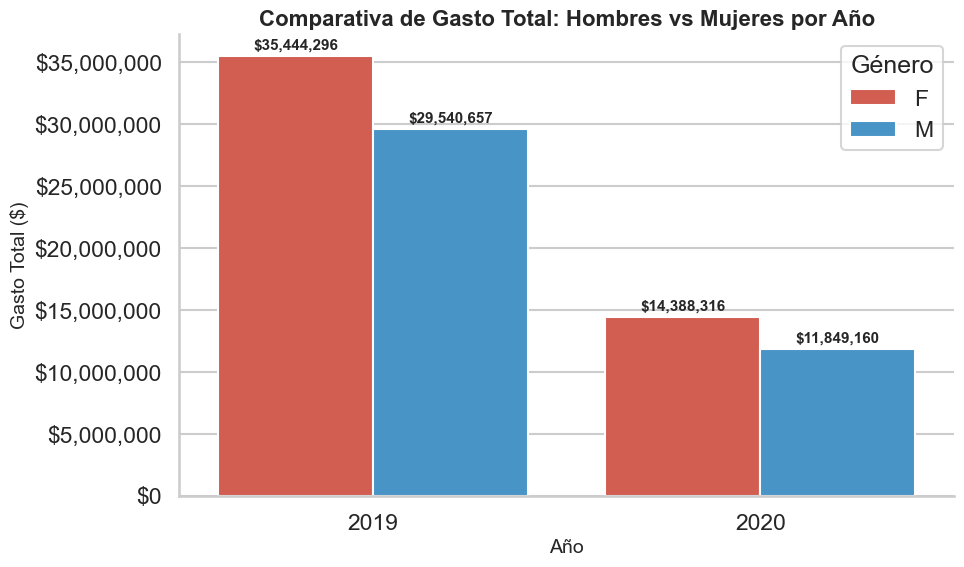

In [128]:
# --- Evolución del Gasto por Género y Año ---

# Agrupamos por Año y Género
gasto_genero_anio = df.groupby(['Año', 'gender'])['amt'].sum().reset_index()

plt.figure(figsize=(10, 6))

# Gráfico de Barras Agrupadas
ax = sns.barplot(data=gasto_genero_anio, x='Año', y='amt', hue='gender', palette={'M': '#3498db', 'F': '#e74c3c'})

plt.title('Comparativa de Gasto Total: Hombres vs Mujeres por Año', fontsize=16, fontweight='bold')
plt.xlabel('Año')
plt.ylabel('Gasto Total ($)')
plt.legend(title='Género')

# Formato de dinero
ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Etiquetas de valor encima de cada barra para facilitar la lectura
for container in ax.containers:
    ax.bar_label(container, fmt='${:,.0f}', padding=3, fontsize=11, fontweight='bold')

sns.despine()
plt.savefig(graficos_dir / 'gasto_genero_anio.png', bbox_inches='tight')
plt.show()

Gráfico de Barras Agrupadas: Gasto Total por Género y Año

Este gráfico compara el volumen total de transacciones desglosado por Año y Género.

Interpretación: Se observa que el segmento femenino (F) supera consistentemente al masculino (M) en gasto total durante ambos años. En 2019, las mujeres gastaron $35.4M frente a $29.5M de los hombres, manteniendo esta superioridad en 2020 ($14.3M vs $11.8M). Esto indica que las mujeres son el principal motor económico en este conjunto de datos .

# Evolución de transacciones mensuales por categoría. 

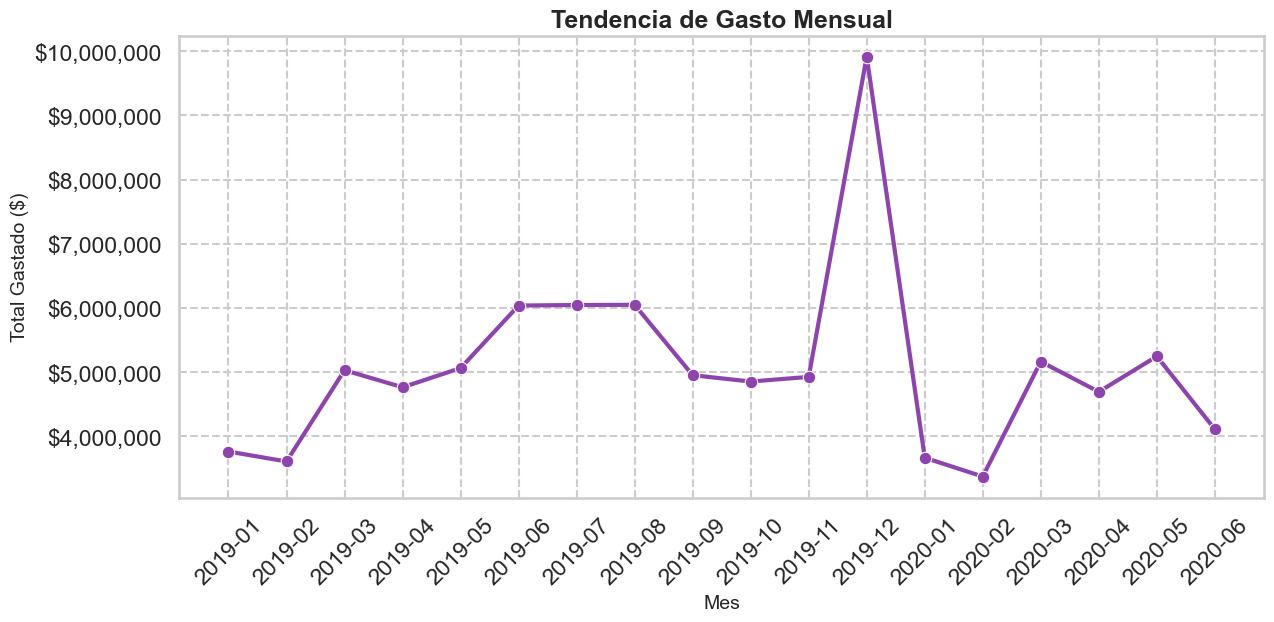

In [129]:
# Evolución Mensual (Tendencia)
gasto_mes = df.groupby('Periodo')['amt'].sum().reset_index()
gasto_mes['Periodo'] = gasto_mes['Periodo'].astype(str)

plt.figure(figsize=(14, 6))
sns.lineplot(data=gasto_mes, x='Periodo', y='amt', marker='o', linewidth=3, color='#8e44ad')

plt.title('Tendencia de Gasto Mensual', fontweight='bold')
plt.xlabel('Mes')
plt.ylabel('Total Gastado ($)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.savefig(graficos_dir / 'linea_tendencia.png', bbox_inches='tight')
plt.show()


Gráfico de Línea: Tendencia de Gasto Mensual

Este gráfico muestra la evolución del monto total de transacciones (eje Y) a lo largo de los meses (eje X) entre 2019 y 2020.

 El comportamiento del gasto es relativamente estable durante gran parte de 2019, oscilando entre $4 y $6 millones. El dato más relevante es el pico drástico en diciembre de 2019, donde el consumo se dispara hasta casi $10 millones, marcando una clara estacionalidad de fin de año. Posteriormente, el inicio de 2020 registra una caída abrupta a los niveles mínimos de la serie (cerca de $3.5M), seguida de una recuperación moderada sin alcanzar los niveles previos.

##  Categorías (¿En qué gastan?)
Las 5 categorías principales donde se va el dinero.


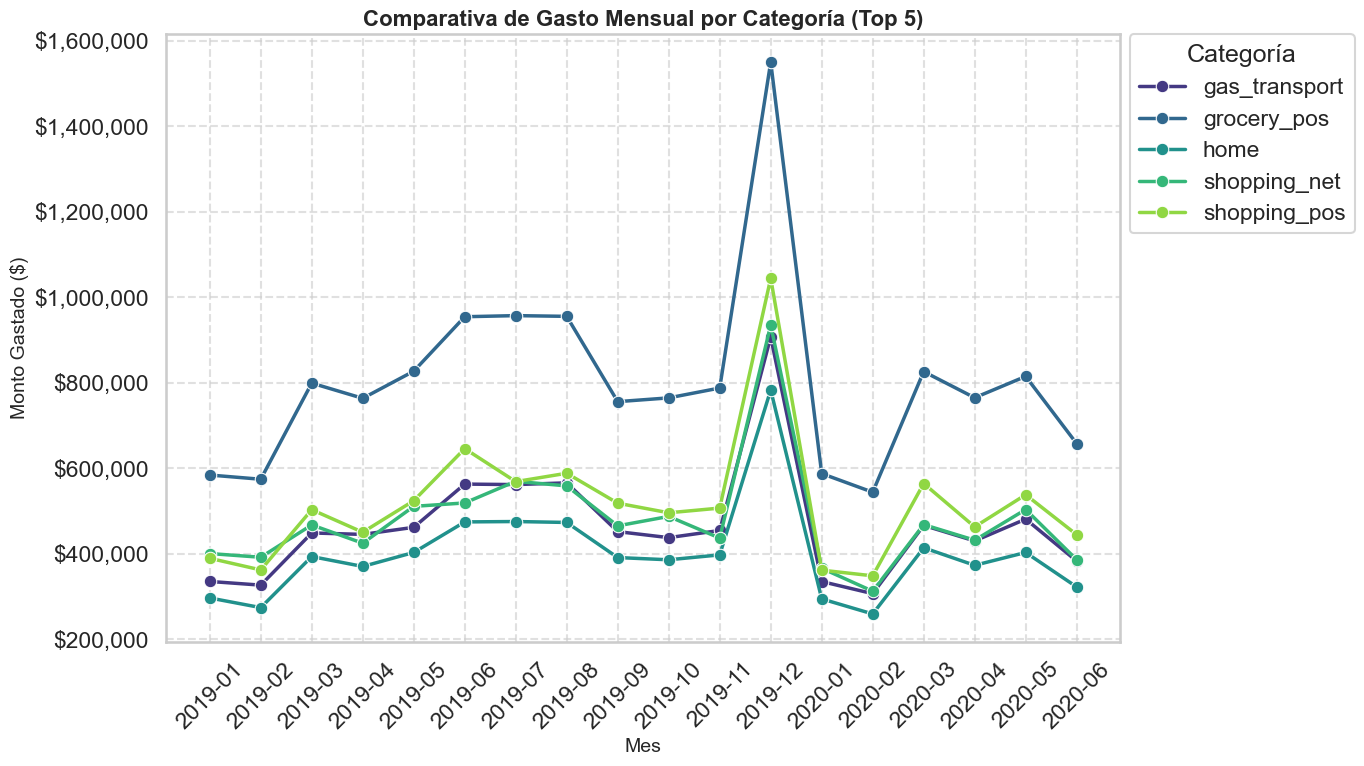

In [130]:
# Evolución Mensual por Categoría

# 1. Identificamos el Top 5 Categorías
top_cats_list = df.groupby('category')['amt'].sum().sort_values(ascending=False).head(5).index.tolist()

# 2. Filtramos los datos para quedarnos solo con esas categorías
df_top = df[df['category'].isin(top_cats_list)]

# 3. Agrupamos por Periodo y Categoría
# Convertimos el periodo a string para
data_lineas = df_top.groupby(['Periodo', 'category'])['amt'].sum().reset_index()
data_lineas['Periodo'] = data_lineas['Periodo'].astype(str)

# 4. Graficamos
plt.figure(figsize=(14, 8))

# 'hue' separa las líneas por color según la categoría
# 'marker' pone puntitos en cada mes para ver mejor el dato
sns.lineplot(data=data_lineas, x='Periodo', y='amt', hue='category', marker='o', linewidth=2.5, palette='viridis')

plt.title('Comparativa de Gasto Mensual por Categoría (Top 5)', fontsize=16, fontweight='bold')
plt.xlabel('Mes')
plt.ylabel('Monto Gastado ($)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)

# Formato de dinero en eje Y
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Leyenda 
plt.legend(title='Categoría', bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0)

plt.tight_layout()
plt.savefig(graficos_dir / 'lineas_evolucion_categorias.png')
plt.show()

Gráfico de Líneas Múltiples: Comparativa de Gasto Mensual por Categoría (Top 5)

Este gráfico desglosa la evolución mensual del gasto en las 5 categorías principales: grocery_pos (Supermercado), shopping_pos (Compras físicas), home (Hogar), shopping_net (Compras online) y gas_transport (Gasolina/Transporte).

Interpretación: La categoría grocery_pos domina consistentemente el gasto durante todo el periodo, manteniéndose siempre por encima de las demás. Se observa un patrón estacional muy marcado en diciembre de 2019, donde todas las categorías experimentan un pico simultáneo, siendo grocery_pos la que alcanza el máximo histórico (~$1.5M). Las demás categorías (shopping, home, gas) siguen tendencias muy similares entre sí, moviéndose en bloque con valores entre $400k y $600k, lo que sugiere una correlación en el comportamiento de consumo general más allá del rubro específico.

# Distribución Geográfica del Gasto (Top 10 Estados)

 dónde se concentra el poder adquisitivo dentro del conjunto de datos.

C:\Users\eulic\AppData\Local\Temp\ipykernel_20980\671168483.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=top_states_amt, x='amt', y='state_full', palette='Spectral')


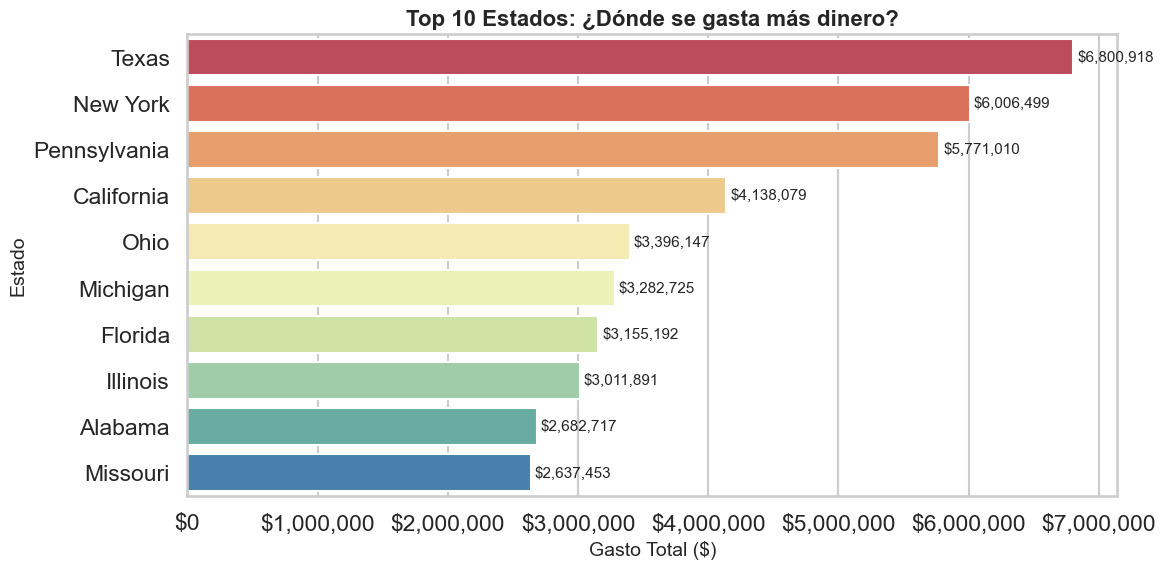

In [131]:
# Top 10 Estados con Mayor Gasto Total 

# Diccionario de Estados de EE.UU.
us_state_abbrev = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California',
    'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia',
    'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa',
    'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri',
    'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio',
    'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont',
    'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'
}

# Calculamos el Top 10
top_states_amt = df.groupby('state')['amt'].sum().sort_values(ascending=False).head(10).reset_index()

# Mapeamos la abreviatura al nombre completo
# Si alguna abreviatura no está en el diccionario, deja la original
top_states_amt['state_full'] = top_states_amt['state'].map(us_state_abbrev).fillna(top_states_amt['state'])

plt.figure(figsize=(12, 6))
# Usamos 'state_full' en el eje Y
ax = sns.barplot(data=top_states_amt, x='amt', y='state_full', palette='Spectral')

plt.title('Top 10 Estados: ¿Dónde se gasta más dinero?', fontsize=16, fontweight='bold')
plt.xlabel('Gasto Total ($)')
plt.ylabel('Estado')

# Formato de dinero en eje X
ax.xaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# Etiquetas de valor
for container in ax.containers:
    ax.bar_label(container, fmt='${:,.0f}', padding=3, fontsize=11)

plt.savefig(graficos_dir / 'top_10_estados_gasto_nombres.png', bbox_inches='tight')
plt.show()

Gráfico de Barras Horizontales: Top 10 Estados por Gasto Total

Este gráfico clasifica los 10 estados con mayor volumen acumulado de transacciones, permitiendo identificar los mercados geográficos más importantes.

Texas lidera el ranking con un gasto total de $6.8 millones, seguido de cerca por New York ($6.0M) y Pennsylvania ($5.7M). Estos tres estados conforman el podio económico, concentrando una parte muy significativa del volumen total. Existe un salto notable entre el tercer lugar (Pennsylvania) y el cuarto (California, $4.1M), lo que indica que el consumo en este dataset está particularmente polarizado en los tres primeros estados. El resto del Top 10 (Ohio, Michigan, Florida, etc.) muestra un descenso gradual, manteniéndose en el rango de los $2.6M a $3.4M.

# Evolución Temporal del gasto Promedio
Analisis del gasto promedio de las transacciones por mes y año con respecto al género.

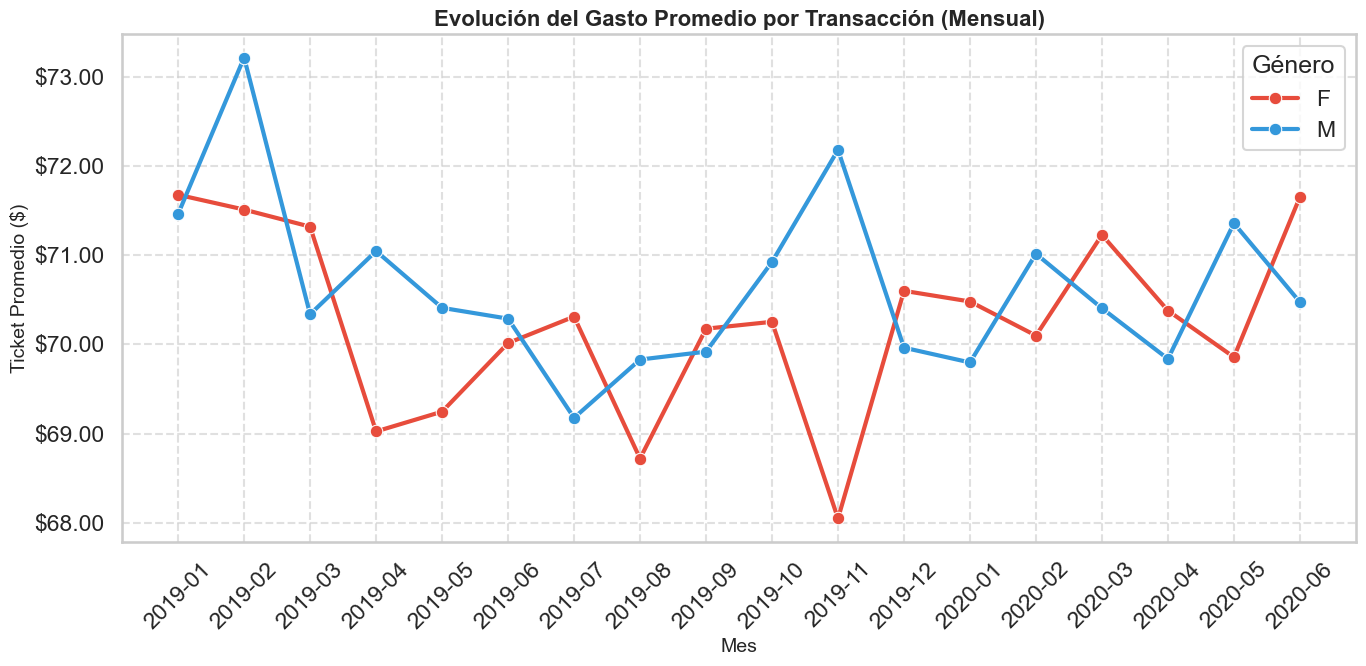

In [132]:
# --- Evolución del Gasto Promedio Mensual por Género ---

# 1. Agrupamos por Periodo (Mes) y Género, calculando el PROMEDIO ('mean')
# Convertimos 'Periodo' a string para que el gráfico lo ordene bien
gasto_promedio_tiempo = df.groupby(['Periodo', 'gender'])['amt'].mean().reset_index()
gasto_promedio_tiempo['Periodo'] = gasto_promedio_tiempo['Periodo'].astype(str)

plt.figure(figsize=(14, 7))

# 2. Gráfico de Líneas
# 'hue' crea dos líneas separadas (Hombres vs Mujeres)
sns.lineplot(
    data=gasto_promedio_tiempo, 
    x='Periodo', 
    y='amt', 
    hue='gender', 
    marker='o', 
    linewidth=3, 
    palette={'M': '#3498db', 'F': '#e74c3c'}
)

plt.title('Evolución del Gasto Promedio por Transacción (Mensual)', fontsize=16, fontweight='bold')
plt.xlabel('Mes')
plt.ylabel('Ticket Promedio ($)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Género')

# Formato de dinero en eje Y
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.2f}'))

plt.tight_layout()
plt.savefig(graficos_dir / 'evolucion_ticket_promedio_genero.png')
plt.show()

Gráfico de Línea: Evolución del Ticket Promedio Mensual por Género

Este gráfico compara el valor promedio de cada transacción (Ticket Promedio) entre hombres (azul) y mujeres (rojo) a lo largo del tiempo.

Interpretación y Análisis de la Caída en Noviembre (2019-11): Se observa una volatilidad constante en el ticket promedio de ambos géneros, oscilando generalmente entre $69 y $72. Sin embargo, destaca una caída abrupta en el ticket promedio de las mujeres en Noviembre de 2019, alcanzando su punto mínimo anual (~$68).


# Evolución de las Top Categorías por Género 
donde se observa que hay una tendencia de compra con respecto al género

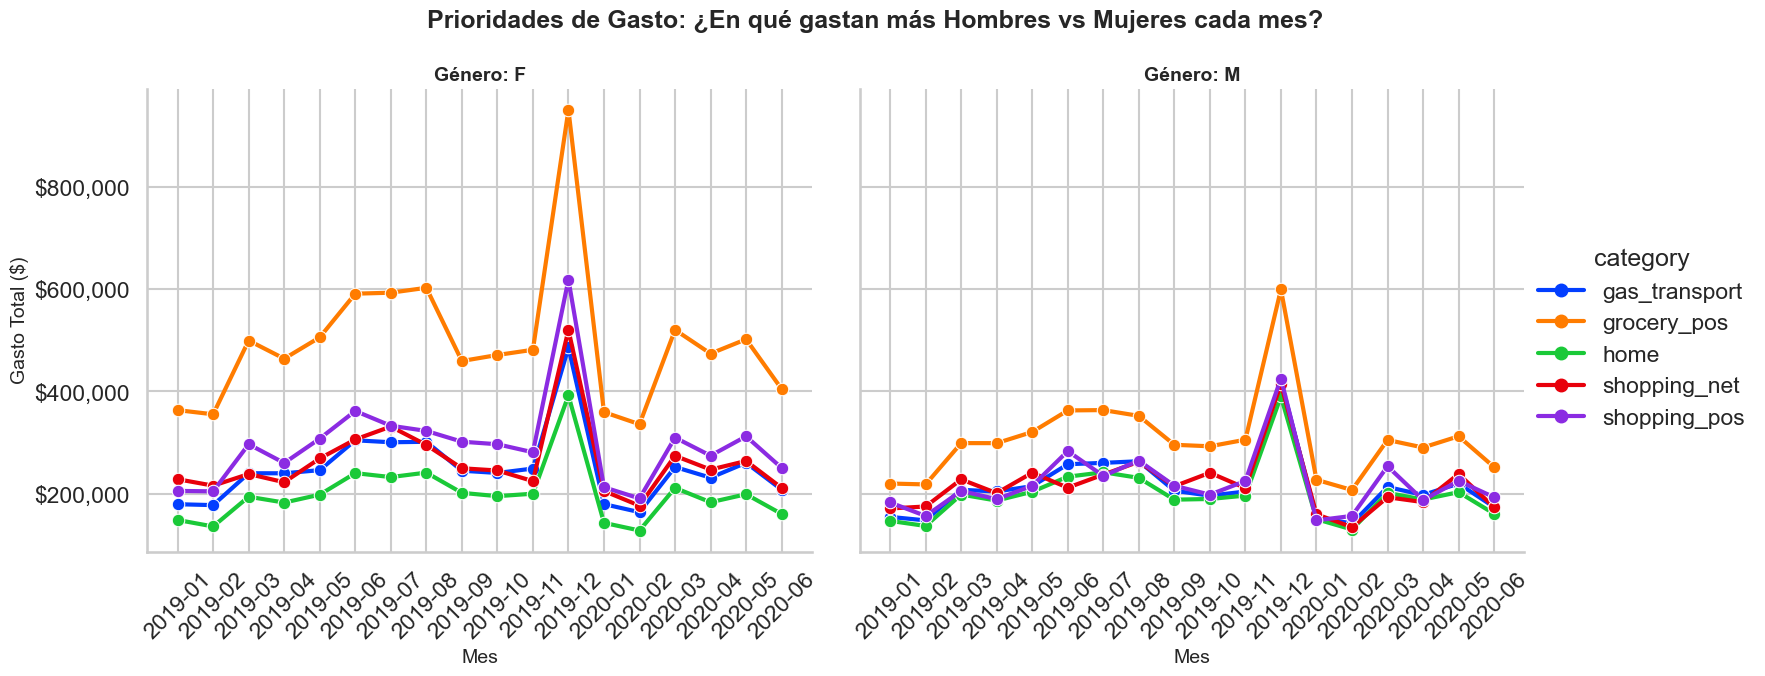

In [133]:
# --- Evolución de las Top Categorías por Género (Comparativa) ---

# 1. Identificamos las 5 categorías más importantes en general (para no ensuciar el gráfico)
top_categories = df.groupby('category')['amt'].sum().sort_values(ascending=False).head(5).index.tolist()

# 2. Filtramos los datos
df_cat_gen_time = df[df['category'].isin(top_categories)].copy()

# 3. Agrupamos por Periodo, Género y Categoría
data_evolution = df_cat_gen_time.groupby(['Periodo', 'gender', 'category'])['amt'].sum().reset_index()
data_evolution['Periodo'] = data_evolution['Periodo'].astype(str)

# 4. Usamos 'relplot' para crear dos gráficos de líneas lado a lado
g = sns.relplot(
    data=data_evolution,
    x="Periodo",
    y="amt",
    hue="category",  # Cada línea es una categoría
    col="gender",    # Divide en dos gráficos: M y F
    kind="line",
    height=6,
    aspect=1.3,
    marker='o',
    linewidth=3,
    palette='bright' # Colores vivos para distinguir categorías
)

# 5. Ajustes Estéticos
g.fig.suptitle('Prioridades de Gasto: ¿En qué gastan más Hombres vs Mujeres cada mes?', fontsize=18, fontweight='bold', y=1.05)
g.set_titles("Género: {col_name}", fontweight='bold', size=14)
g.set_axis_labels("Mes", "Gasto Total ($)")

# Rotar fechas y formato de dinero
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

plt.savefig(graficos_dir / 'evolucion_categorias_por_genero.png', bbox_inches='tight')
plt.show()

Gráfico de Líneas Facetado (Comparativo)

Variables: Mes (Tiempo), Gasto Total (amt), Categoría (Top 5) y Género.

Interpretación: Ambos géneros siguen patrones de consumo casi idénticos, con la categoría Supermercado (grocery_pos) liderando siempre el gasto, seguida de compras físicas y transporte. La principal diferencia es el volumen: las mujeres gastan significativamente más en todas las categorías, especialmente durante el pico estacional de Diciembre, donde el consumo se dispara universalmente.

# Proporción de Gasto + Gasto Total 
gastos por genero en los estados distinguidos por el porcentaje de gasto.


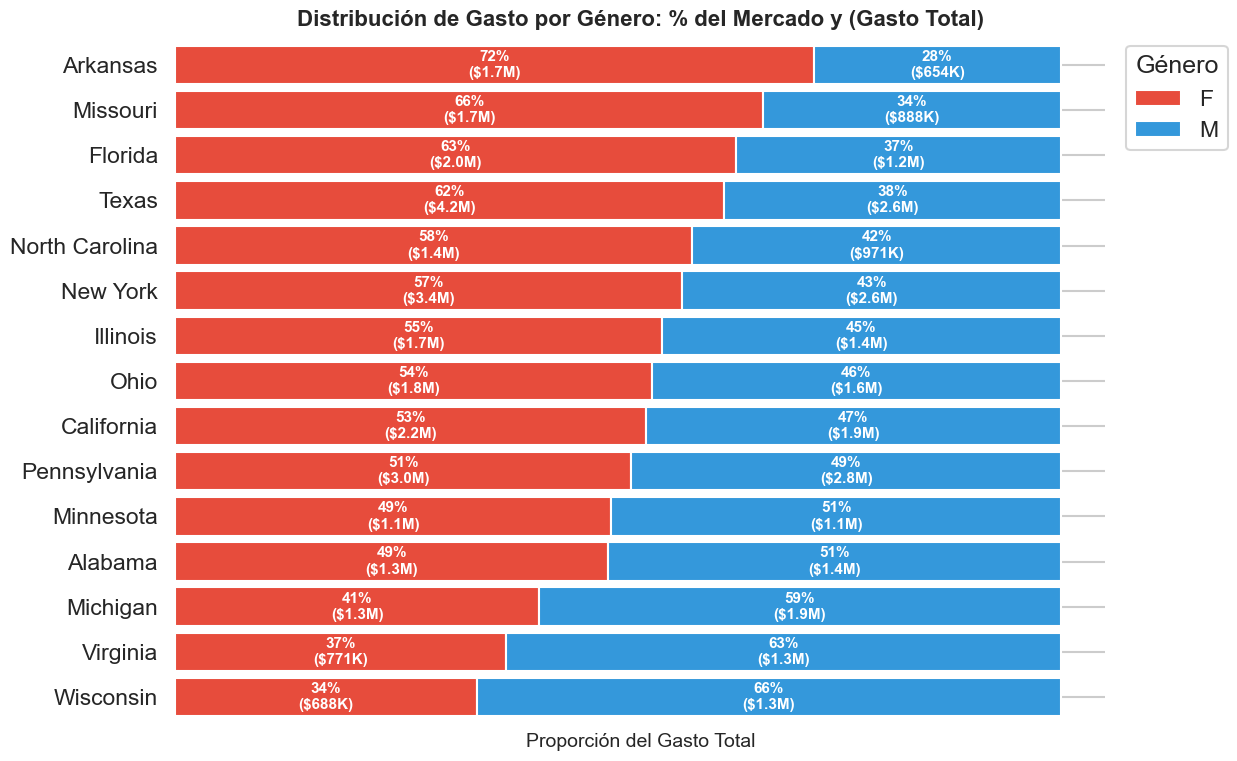

In [134]:
# --- Proporción de Gasto + Gasto Total (Barras 100% Apiladas) ---

# 1. Preparación de datos (Top 10 Estados)
top_10_states = df.groupby('state')['amt'].sum().sort_values(ascending=False).head(15).index.tolist()
df_prop = df[df['state'].isin(top_10_states)].copy()

if 'us_state_abbrev' in locals():
    df_prop['state_full'] = df_prop['state'].map(us_state_abbrev).fillna(df_prop['state'])
else:
    df_prop['state_full'] = df_prop['state']

# 2. Calculamos tablas pivote
# A) Gasto Total (Suma)
pivot_sum = df_prop.pivot_table(index='state_full', columns='gender', values='amt', aggfunc='sum')
# B) Porcentaje (Proporción)
pivot_pct = pivot_sum.div(pivot_sum.sum(axis=1), axis=0)

# Ordenamos por el % de Mujeres
pivot_pct = pivot_pct.sort_values('F', ascending=True)
# Alineamos la tabla de sumas
pivot_sum = pivot_sum.reindex(pivot_pct.index)

# 3. Graficamos
ax = pivot_pct.plot(kind='barh', stacked=True, figsize=(12, 9), color=['#e74c3c', '#3498db'], width=0.85)

plt.title('Distribución de Gasto por Género: % del Mercado y (Gasto Total)', fontsize=16, fontweight='bold')
plt.xlabel('Proporción del Gasto Total')
plt.ylabel('') 
plt.legend(title='Género', bbox_to_anchor=(1.01, 1), loc='upper left')
plt.xticks([]) # Limpiamos eje X

# 4. Etiquetas personalizadas
for col_idx, col_name in enumerate(pivot_pct.columns):
    container = ax.containers[col_idx]
    labels = []
    
    for i, bar in enumerate(container):
        pct_val = bar.get_width()
        sum_val = pivot_sum.iloc[i, col_idx] # Valor Total en Dinero
        
        if pct_val > 0.08:
            # Formato: "45%\n($1,200,500)"
            # Usamos K (Miles) o M (Millones) si los números son muy grandes para que quepa
            if sum_val >= 1_000_000:
                val_str = f"${sum_val/1_000_000:.1f}M"
            else:
                val_str = f"${sum_val/1_000:.0f}K"
                
            label_text = f"{pct_val:.0%}\n({val_str})"
        else:
            label_text = ""
        labels.append(label_text)
    
    ax.bar_label(container, labels=labels, label_type='center', fontsize=11, fontweight='bold', color='white')

sns.despine(left=True, bottom=True)
plt.savefig(graficos_dir / 'proporcion_genero_gasto_total.png', bbox_inches='tight')
plt.show()

Gráfico de Barras Apiladas (100%): Distribución de Gasto por Género

Variables: Estado, Proporción de Gasto (%), Gasto Total ($) y Género.

Interpretación: Existe una clara disparidad regional en el comportamiento de gasto. Estados como Arkansas y Missouri están fuertemente dominados por el consumo femenino (72% y 66% respectivamente). En contraste, estados como Wisconsin, Virginia y Michigan muestran la tendencia opuesta, con una mayoría de gasto masculino (llegando al 66% en Wisconsin). Los grandes mercados como New York y California presentan un perfil más equilibrado, aunque con una ligera inclinación hacia el segmento femenino.

# Matriz de Correlación 

correlación entre variables

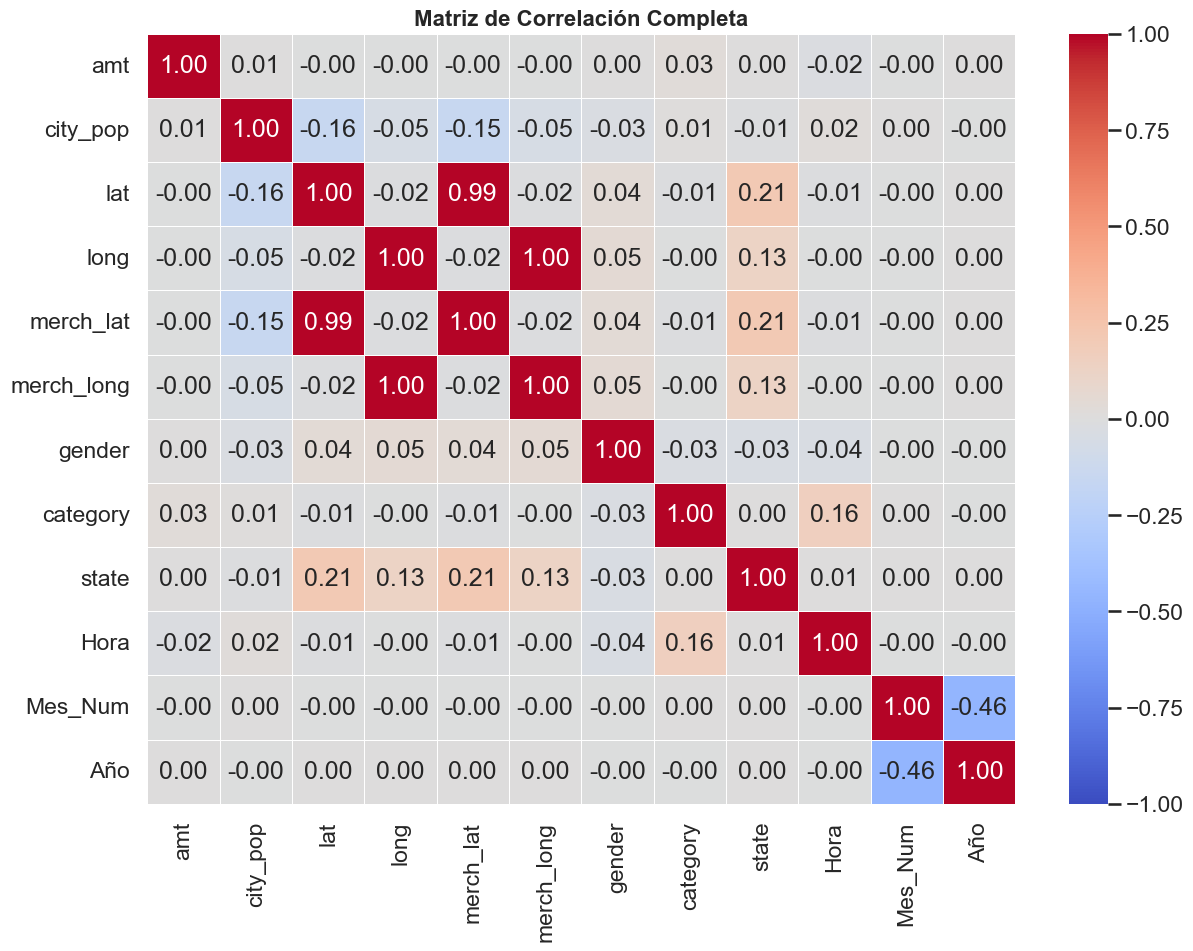

In [135]:
# Matriz de Correlación 

# Hacemos una copia 
df_corr = df.copy()

# ---  Crear las columnas numéricas de tiempo ---
df_corr['Mes_Num'] = df_corr['trans_date_trans_time'].dt.month
df_corr['Hora'] = df_corr['trans_date_trans_time'].dt.hour
df_corr['Año'] = df_corr['trans_date_trans_time'].dt.year

# Lista de variables que queremos analizar
columnas_a_analizar = [
    'amt', 'city_pop', 'lat', 'long', 'merch_lat', 'merch_long',  # Numéricas
    'gender', 'category', 'state',                                # Texto (Categóricas)
    'Hora', 'Mes_Num', 'Año'                                      # Tiempo
]

# Convertimos las columnas de texto a números 
for col in ['gender', 'category', 'state']:
    df_corr[col] = df_corr[col].astype('category').cat.codes

# Calculamos la correlación solo de estas columnas
matriz_corr = df_corr[columnas_a_analizar].corr()

# Graficamos
plt.figure(figsize=(14, 10))
sns.heatmap(matriz_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

plt.title('Matriz de Correlación Completa', fontsize=16, fontweight='bold')
plt.savefig(graficos_dir / 'matriz_correlacion_completa.png', bbox_inches='tight')
plt.show()

Mapa de Calor: Matriz de Correlación

Variables: Todas las variables numéricas y categóricas del dataset.

Interpretación: El análisis de correlación revela que no existen relaciones lineales fuertes entre la mayoría de las variables del negocio.

El monto de la transacción (amt) es prácticamente independiente de factores como la población de la ciudad (city_pop), la ubicación (lat, long) o el género (gender), con coeficientes cercanos a 0.00.
Las únicas correlaciones fuertes (cercanas a 1.00) son triviales y esperadas: la latitud del usuario (lat) con la del comercio (merch_lat), lo cual confirma que las personas compran cerca de donde viven.
Existe una leve correlación negativa (-0.46) entre Mes_Num y Año, lo cual es un artefacto de los datos (probablemente porque tenemos datos de finales de 2019 y principios de 2020).